In [1]:
# data manipulation
import numpy as np
import pandas as pd

#file processing / requests
from pathlib import Path
from tqdm import tqdm
import json
import urllib

#computer vision
import cv2
import torch
import torchvision

import PIL

#ML 
from sklearn.model_selection import train_test_split


#display
from IPython.display import display
from pylab import rcParams

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import PIL.Image as Image

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce RTX 3090


In [ ]:
## Following https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae

In [14]:
rac = pd.read_csv('train/raccoon_dataset/data/raccoon_labels.csv', sep = ',')
rac

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-1.jpg,650,417,raccoon,81,88,522,408
1,raccoon-10.jpg,450,495,raccoon,130,2,446,488
2,raccoon-100.jpg,960,576,raccoon,548,10,954,520
3,raccoon-101.jpg,640,426,raccoon,86,53,400,356
4,raccoon-102.jpg,259,194,raccoon,1,1,118,152
...,...,...,...,...,...,...,...,...
212,raccoon-95.jpg,320,400,raccoon,50,45,272,289
213,raccoon-96.jpg,230,219,raccoon,28,25,203,175
214,raccoon-97.jpg,500,393,raccoon,1,32,343,307
215,raccoon-98.jpg,480,360,raccoon,108,31,351,308


In [4]:
import pycocotools

In [26]:
%pwd

'/Users/phil0/DS/IEEE'

In [20]:
import sys
# sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

labelsdict = {'D00':'Longitudinal Crack','D10':'Lateral Crack','D20':'Alligator Crack','D40':'Pothole'}
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

from xml.dom import minidom

xmls = xml_to_csv(path = 'train/annotations', labelsdict = labelsdict)
xmls.to_csv('train/ieee_dataset_1210.csv')
xmls.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Czech_000006.jpg,600,600,Longitudinal Crack,141,405,166,472
1,Czech_000010.jpg,600,600,Pothole,213,409,274,441
2,Czech_000010.jpg,600,600,Lateral Crack,228,473,327,495
3,Czech_000020.jpg,600,600,Lateral Crack,97,477,167,499
4,Czech_000020.jpg,600,600,Lateral Crack,110,443,180,465


In [23]:
xmls['area'] = (xmls['xmax'].astype(int) - xmls['xmin'].astype(int)) * (xmls['ymax'].astype(int) - xmls['ymin'].astype(int))
xmls.loc[xmls['area'] <= 1]

,filename,width,height,class,xmin,ymin,xmax,ymax,area
10163,Japan_001265.jpg,600,600,Alligator Crack,198,474,199,475,1


In [9]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

NOTE! Installing ujson may make loading annotations faster.


In [10]:
def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data["filename"] == filename][["xmin", "ymin","xmax", "ymax"]].values
    return boxes_array

class IEEEDataset(torch.utils.data.Dataset):
   
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "images")))
        self.path_to_data_file = data_file

    def __getitem__(self, idx):
          # load images and bounding boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        box_list = parse_one_annot(self.path_to_data_file, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
    
        num_objs = len(box_list)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return len(self.imgs)
    

In [11]:
dataset = IEEEDataset(root = 'train', data_file= 'train/ieee_dataset_1210.csv')
dataset.__getitem__(3)

(<PIL.Image.Image image mode=RGB size=600x600 at 0x7FAC9A608A90>,
 {'boxes': tensor([[141., 405., 166., 472.]]),
  'labels': tensor([1]),
  'image_id': tensor([3]),
  'area': tensor([1675.]),
  'iscrowd': tensor([0])})

In [12]:
dataset.__getitem__(6)

(<PIL.Image.Image image mode=RGB size=600x600 at 0x7FCAE69BDE80>,
 {'boxes': tensor([[213., 409., 274., 441.],
          [228., 473., 327., 495.]]),
  'labels': tensor([1, 1]),
  'image_id': tensor([6]),
  'area': tensor([1952., 2178.]),
  'iscrowd': tensor([0, 0])})

In [7]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.\
           fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
   
    return model

In [5]:
def get_transform(train = False):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [72]:
import random
valmask = random.sample(list(range(0,21041)), 420)
# valmask = [random.randrange(0, 21041) for _ in range(420)]
trainmask = [i for i in range(0,21041) if i not in valmask]
print(len(valmask), len(trainmask), len(trainmask)+len(valmask))

420 20621 21041


In [25]:
def get_dataloaders(idx_cutoff, train_batch_size, num_workers = 0):
    # use our dataset and defined transformations
    dataset = IEEEDataset(root= 'train',  data_file= 'train/ieee_dataset_1210.csv', transforms = get_transform(train=False))
    dataset_test = IEEEDataset(root= 'train', data_file= 'train/ieee_dataset_1210.csv', transforms = get_transform(train=False))
    # split the dataset in train and test set
    torch.manual_seed(1)
    indices = torch.randperm(len(dataset)).tolist()
    # valindices = torch.randperm(valmask).tolist()
    # trainindices = torch.randperm(trainmask).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-idx_cutoff])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-idx_cutoff:])
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
                  dataset, batch_size=train_batch_size, shuffle=True, num_workers=num_workers,
                  collate_fn=utils.collate_fn)
    data_loader_test = torch.utils.data.DataLoader(
             dataset_test, batch_size=1, shuffle=False, num_workers=num_workers,
             collate_fn=utils.collate_fn)
    print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))
    return dataset, dataset_test, data_loader, data_loader_test

dataset, dataset_test, data_loader, data_loader_test = get_dataloaders(idx_cutoff = 420, train_batch_size = 16, num_workers = 0)

We have: 21041 examples, 20621 are training and 420 testing


In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - raccoon and not racoon
num_classes = 4
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.95)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [19]:
1289 * 16

20624

In [ ]:
#2 batch size 16 12/12

num_epochs = 300
for idx, epoch in enumerate(range(num_epochs)):
    if idx % 50 == 0:
        torch.save(model.state_dict(), f'''train/weights/model_1210_fastrcnn_{idx}''')
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch,
                   print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1289]  eta: 0:31:39  lr: 0.000010  loss: 0.2541 (0.2541)  loss_classifier: 0.1085 (0.1085)  loss_box_reg: 0.1222 (0.1222)  loss_objectness: 0.0161 (0.0161)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 1.4738  data: 0.4663  max mem: 11833
Epoch: [0]  [  10/1289]  eta: 0:31:25  lr: 0.000060  loss: 0.1778 (0.1966)  loss_classifier: 0.0707 (0.0780)  loss_box_reg: 0.0812 (0.0891)  loss_objectness: 0.0157 (0.0184)  loss_rpn_box_reg: 0.0076 (0.0110)  time: 1.4741  data: 0.4663  max mem: 11833
Epoch: [0]  [  20/1289]  eta: 0:31:26  lr: 0.000110  loss: 0.1869 (0.1938)  loss_classifier: 0.0788 (0.0792)  loss_box_reg: 0.0885 (0.0895)  loss_objectness: 0.0134 (0.0155)  loss_rpn_box_reg: 0.0073 (0.0096)  time: 1.4871  data: 0.4656  max mem: 11833
Epoch: [0]  [  30/1289]  eta: 0:31:15  lr: 0.000160  loss: 0.1869 (0.1939)  loss_classifier: 0.0797 (0.0788)  loss_box_reg: 0.0885 (0.0901)  loss_objectness: 0.0138 (0.0154)  loss_rpn_box_reg: 0.0073 (0.0096)  time: 1.4978  data: 0.4616  max

Epoch: [0]  [ 330/1289]  eta: 0:23:40  lr: 0.001658  loss: 0.1875 (0.1941)  loss_classifier: 0.0740 (0.0756)  loss_box_reg: 0.0892 (0.0905)  loss_objectness: 0.0130 (0.0174)  loss_rpn_box_reg: 0.0083 (0.0107)  time: 1.4658  data: 0.4622  max mem: 11833
Epoch: [0]  [ 340/1289]  eta: 0:23:26  lr: 0.001708  loss: 0.2124 (0.1947)  loss_classifier: 0.0801 (0.0758)  loss_box_reg: 0.1010 (0.0907)  loss_objectness: 0.0141 (0.0173)  loss_rpn_box_reg: 0.0085 (0.0108)  time: 1.4772  data: 0.4724  max mem: 11833
Epoch: [0]  [ 350/1289]  eta: 0:23:11  lr: 0.001758  loss: 0.2091 (0.1944)  loss_classifier: 0.0820 (0.0758)  loss_box_reg: 0.0962 (0.0905)  loss_objectness: 0.0143 (0.0173)  loss_rpn_box_reg: 0.0079 (0.0108)  time: 1.4879  data: 0.4820  max mem: 11833
Epoch: [0]  [ 360/1289]  eta: 0:22:56  lr: 0.001808  loss: 0.1680 (0.1933)  loss_classifier: 0.0654 (0.0754)  loss_box_reg: 0.0799 (0.0900)  loss_objectness: 0.0127 (0.0172)  loss_rpn_box_reg: 0.0054 (0.0107)  time: 1.4885  data: 0.4832  max

Epoch: [0]  [ 660/1289]  eta: 0:15:31  lr: 0.003307  loss: 0.1881 (0.1942)  loss_classifier: 0.0755 (0.0763)  loss_box_reg: 0.0906 (0.0907)  loss_objectness: 0.0145 (0.0167)  loss_rpn_box_reg: 0.0064 (0.0105)  time: 1.4740  data: 0.4625  max mem: 11833
Epoch: [0]  [ 670/1289]  eta: 0:15:16  lr: 0.003357  loss: 0.1953 (0.1943)  loss_classifier: 0.0734 (0.0764)  loss_box_reg: 0.0924 (0.0908)  loss_objectness: 0.0145 (0.0167)  loss_rpn_box_reg: 0.0069 (0.0105)  time: 1.4681  data: 0.4620  max mem: 11833
Epoch: [0]  [ 680/1289]  eta: 0:15:01  lr: 0.003407  loss: 0.2008 (0.1943)  loss_classifier: 0.0766 (0.0763)  loss_box_reg: 0.0984 (0.0908)  loss_objectness: 0.0166 (0.0167)  loss_rpn_box_reg: 0.0084 (0.0105)  time: 1.4667  data: 0.4605  max mem: 11833
Epoch: [0]  [ 690/1289]  eta: 0:14:46  lr: 0.003457  loss: 0.1871 (0.1944)  loss_classifier: 0.0770 (0.0764)  loss_box_reg: 0.0843 (0.0909)  loss_objectness: 0.0165 (0.0166)  loss_rpn_box_reg: 0.0089 (0.0104)  time: 1.4678  data: 0.4606  max

Epoch: [0]  [ 990/1289]  eta: 0:07:23  lr: 0.004955  loss: 0.1947 (0.1934)  loss_classifier: 0.0763 (0.0760)  loss_box_reg: 0.0954 (0.0908)  loss_objectness: 0.0115 (0.0164)  loss_rpn_box_reg: 0.0089 (0.0103)  time: 1.4893  data: 0.4781  max mem: 11833
Epoch: [0]  [1000/1289]  eta: 0:07:08  lr: 0.005000  loss: 0.1971 (0.1933)  loss_classifier: 0.0789 (0.0759)  loss_box_reg: 0.0954 (0.0907)  loss_objectness: 0.0101 (0.0163)  loss_rpn_box_reg: 0.0089 (0.0103)  time: 1.5035  data: 0.4839  max mem: 11833
Epoch: [0]  [1010/1289]  eta: 0:06:53  lr: 0.005000  loss: 0.2022 (0.1934)  loss_classifier: 0.0789 (0.0760)  loss_box_reg: 0.0981 (0.0908)  loss_objectness: 0.0130 (0.0163)  loss_rpn_box_reg: 0.0078 (0.0103)  time: 1.5135  data: 0.4855  max mem: 11833
Epoch: [0]  [1020/1289]  eta: 0:06:38  lr: 0.005000  loss: 0.2061 (0.1936)  loss_classifier: 0.0787 (0.0760)  loss_box_reg: 0.0981 (0.0909)  loss_objectness: 0.0151 (0.0163)  loss_rpn_box_reg: 0.0101 (0.0103)  time: 1.5029  data: 0.4856  max

Test:  [200/420]  eta: 0:00:16  model_time: 0.0416 (0.0417)  evaluator_time: 0.0050 (0.0048)  time: 0.0774  data: 0.0300  max mem: 11833
Test:  [300/420]  eta: 0:00:09  model_time: 0.0416 (0.0417)  evaluator_time: 0.0046 (0.0048)  time: 0.0768  data: 0.0295  max mem: 11833
Test:  [400/420]  eta: 0:00:01  model_time: 0.0417 (0.0417)  evaluator_time: 0.0047 (0.0048)  time: 0.0773  data: 0.0295  max mem: 11833
Test:  [419/420]  eta: 0:00:00  model_time: 0.0416 (0.0417)  evaluator_time: 0.0048 (0.0048)  time: 0.0774  data: 0.0296  max mem: 11833
Test: Total time: 0:00:32 (0.0769 s / it)
Averaged stats: model_time: 0.0416 (0.0417)  evaluator_time: 0.0048 (0.0048)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.20268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.45506
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.13431
 Average Precision 

Epoch: [1]  [ 260/1289]  eta: 0:25:10  lr: 0.005000  loss: 0.1744 (0.1870)  loss_classifier: 0.0670 (0.0731)  loss_box_reg: 0.0847 (0.0907)  loss_objectness: 0.0116 (0.0136)  loss_rpn_box_reg: 0.0074 (0.0097)  time: 1.4840  data: 0.4729  max mem: 11833
Epoch: [1]  [ 270/1289]  eta: 0:24:56  lr: 0.005000  loss: 0.1786 (0.1877)  loss_classifier: 0.0654 (0.0735)  loss_box_reg: 0.0839 (0.0912)  loss_objectness: 0.0098 (0.0135)  loss_rpn_box_reg: 0.0076 (0.0096)  time: 1.4838  data: 0.4694  max mem: 11833
Epoch: [1]  [ 280/1289]  eta: 0:24:42  lr: 0.005000  loss: 0.1712 (0.1874)  loss_classifier: 0.0744 (0.0733)  loss_box_reg: 0.0839 (0.0909)  loss_objectness: 0.0096 (0.0135)  loss_rpn_box_reg: 0.0076 (0.0097)  time: 1.4833  data: 0.4695  max mem: 11833
Epoch: [1]  [ 290/1289]  eta: 0:24:28  lr: 0.005000  loss: 0.1627 (0.1870)  loss_classifier: 0.0650 (0.0731)  loss_box_reg: 0.0806 (0.0908)  loss_objectness: 0.0102 (0.0135)  loss_rpn_box_reg: 0.0070 (0.0097)  time: 1.4863  data: 0.4730  max

Epoch: [1]  [ 590/1289]  eta: 0:17:07  lr: 0.005000  loss: 0.1789 (0.1877)  loss_classifier: 0.0693 (0.0731)  loss_box_reg: 0.0875 (0.0910)  loss_objectness: 0.0129 (0.0138)  loss_rpn_box_reg: 0.0067 (0.0098)  time: 1.4783  data: 0.4593  max mem: 11833
Epoch: [1]  [ 600/1289]  eta: 0:16:52  lr: 0.005000  loss: 0.1789 (0.1874)  loss_classifier: 0.0677 (0.0730)  loss_box_reg: 0.0844 (0.0908)  loss_objectness: 0.0123 (0.0138)  loss_rpn_box_reg: 0.0080 (0.0098)  time: 1.4784  data: 0.4610  max mem: 11833
Epoch: [1]  [ 610/1289]  eta: 0:16:38  lr: 0.005000  loss: 0.1772 (0.1874)  loss_classifier: 0.0692 (0.0730)  loss_box_reg: 0.0844 (0.0908)  loss_objectness: 0.0117 (0.0138)  loss_rpn_box_reg: 0.0080 (0.0098)  time: 1.4845  data: 0.4687  max mem: 11833
Epoch: [1]  [ 620/1289]  eta: 0:16:23  lr: 0.005000  loss: 0.1893 (0.1876)  loss_classifier: 0.0743 (0.0731)  loss_box_reg: 0.0863 (0.0907)  loss_objectness: 0.0117 (0.0139)  loss_rpn_box_reg: 0.0073 (0.0099)  time: 1.4780  data: 0.4619  max

Epoch: [1]  [ 920/1289]  eta: 0:09:02  lr: 0.005000  loss: 0.1738 (0.1881)  loss_classifier: 0.0690 (0.0731)  loss_box_reg: 0.0781 (0.0910)  loss_objectness: 0.0112 (0.0141)  loss_rpn_box_reg: 0.0076 (0.0099)  time: 1.4798  data: 0.4593  max mem: 11833
Epoch: [1]  [ 930/1289]  eta: 0:08:47  lr: 0.005000  loss: 0.1493 (0.1879)  loss_classifier: 0.0630 (0.0731)  loss_box_reg: 0.0682 (0.0909)  loss_objectness: 0.0107 (0.0141)  loss_rpn_box_reg: 0.0078 (0.0099)  time: 1.4812  data: 0.4600  max mem: 11833
Epoch: [1]  [ 940/1289]  eta: 0:08:33  lr: 0.005000  loss: 0.1457 (0.1878)  loss_classifier: 0.0571 (0.0730)  loss_box_reg: 0.0680 (0.0908)  loss_objectness: 0.0107 (0.0141)  loss_rpn_box_reg: 0.0085 (0.0099)  time: 1.4749  data: 0.4574  max mem: 11833
Epoch: [1]  [ 950/1289]  eta: 0:08:18  lr: 0.005000  loss: 0.1681 (0.1879)  loss_classifier: 0.0662 (0.0730)  loss_box_reg: 0.0792 (0.0908)  loss_objectness: 0.0122 (0.0141)  loss_rpn_box_reg: 0.0080 (0.0099)  time: 1.4708  data: 0.4574  max

Epoch: [1]  [1250/1289]  eta: 0:00:57  lr: 0.005000  loss: 0.1812 (0.1878)  loss_classifier: 0.0724 (0.0729)  loss_box_reg: 0.0935 (0.0908)  loss_objectness: 0.0141 (0.0142)  loss_rpn_box_reg: 0.0080 (0.0099)  time: 1.4699  data: 0.4556  max mem: 11833
Epoch: [1]  [1260/1289]  eta: 0:00:42  lr: 0.005000  loss: 0.1645 (0.1876)  loss_classifier: 0.0670 (0.0728)  loss_box_reg: 0.0808 (0.0907)  loss_objectness: 0.0138 (0.0142)  loss_rpn_box_reg: 0.0058 (0.0099)  time: 1.4736  data: 0.4562  max mem: 11833
Epoch: [1]  [1270/1289]  eta: 0:00:27  lr: 0.005000  loss: 0.1574 (0.1877)  loss_classifier: 0.0635 (0.0729)  loss_box_reg: 0.0805 (0.0907)  loss_objectness: 0.0128 (0.0142)  loss_rpn_box_reg: 0.0059 (0.0099)  time: 1.4757  data: 0.4609  max mem: 11833
Epoch: [1]  [1280/1289]  eta: 0:00:13  lr: 0.005000  loss: 0.1913 (0.1876)  loss_classifier: 0.0709 (0.0728)  loss_box_reg: 0.0915 (0.0907)  loss_objectness: 0.0110 (0.0142)  loss_rpn_box_reg: 0.0077 (0.0099)  time: 1.4786  data: 0.4670  max

Epoch: [2]  [ 200/1289]  eta: 0:26:45  lr: 0.005000  loss: 0.1675 (0.1782)  loss_classifier: 0.0627 (0.0691)  loss_box_reg: 0.0827 (0.0886)  loss_objectness: 0.0096 (0.0115)  loss_rpn_box_reg: 0.0080 (0.0090)  time: 1.4692  data: 0.4571  max mem: 11833
Epoch: [2]  [ 210/1289]  eta: 0:26:30  lr: 0.005000  loss: 0.1675 (0.1771)  loss_classifier: 0.0613 (0.0686)  loss_box_reg: 0.0838 (0.0878)  loss_objectness: 0.0096 (0.0116)  loss_rpn_box_reg: 0.0082 (0.0091)  time: 1.4688  data: 0.4549  max mem: 11833
Epoch: [2]  [ 220/1289]  eta: 0:26:15  lr: 0.005000  loss: 0.1721 (0.1774)  loss_classifier: 0.0660 (0.0688)  loss_box_reg: 0.0878 (0.0877)  loss_objectness: 0.0114 (0.0117)  loss_rpn_box_reg: 0.0086 (0.0092)  time: 1.4677  data: 0.4530  max mem: 11833
Epoch: [2]  [ 230/1289]  eta: 0:25:59  lr: 0.005000  loss: 0.1699 (0.1768)  loss_classifier: 0.0660 (0.0686)  loss_box_reg: 0.0853 (0.0875)  loss_objectness: 0.0100 (0.0116)  loss_rpn_box_reg: 0.0072 (0.0091)  time: 1.4645  data: 0.4522  max

Epoch: [2]  [ 530/1289]  eta: 0:18:35  lr: 0.005000  loss: 0.1779 (0.1791)  loss_classifier: 0.0653 (0.0688)  loss_box_reg: 0.0885 (0.0890)  loss_objectness: 0.0089 (0.0120)  loss_rpn_box_reg: 0.0077 (0.0094)  time: 1.4727  data: 0.4727  max mem: 11833
Epoch: [2]  [ 540/1289]  eta: 0:18:20  lr: 0.005000  loss: 0.1634 (0.1791)  loss_classifier: 0.0617 (0.0688)  loss_box_reg: 0.0803 (0.0889)  loss_objectness: 0.0111 (0.0120)  loss_rpn_box_reg: 0.0081 (0.0094)  time: 1.4648  data: 0.4639  max mem: 11833
Epoch: [2]  [ 550/1289]  eta: 0:18:05  lr: 0.005000  loss: 0.1647 (0.1792)  loss_classifier: 0.0637 (0.0689)  loss_box_reg: 0.0861 (0.0890)  loss_objectness: 0.0103 (0.0120)  loss_rpn_box_reg: 0.0059 (0.0094)  time: 1.4588  data: 0.4584  max mem: 11833
Epoch: [2]  [ 560/1289]  eta: 0:17:50  lr: 0.005000  loss: 0.1844 (0.1793)  loss_classifier: 0.0702 (0.0689)  loss_box_reg: 0.0897 (0.0890)  loss_objectness: 0.0108 (0.0120)  loss_rpn_box_reg: 0.0071 (0.0095)  time: 1.4587  data: 0.4584  max

Epoch: [2]  [ 860/1289]  eta: 0:10:28  lr: 0.005000  loss: 0.2011 (0.1799)  loss_classifier: 0.0747 (0.0690)  loss_box_reg: 0.1050 (0.0896)  loss_objectness: 0.0117 (0.0119)  loss_rpn_box_reg: 0.0109 (0.0094)  time: 1.4584  data: 0.4532  max mem: 11833
Epoch: [2]  [ 870/1289]  eta: 0:10:13  lr: 0.005000  loss: 0.1924 (0.1801)  loss_classifier: 0.0653 (0.0691)  loss_box_reg: 0.0844 (0.0897)  loss_objectness: 0.0102 (0.0119)  loss_rpn_box_reg: 0.0085 (0.0094)  time: 1.4571  data: 0.4520  max mem: 11833
Epoch: [2]  [ 880/1289]  eta: 0:09:59  lr: 0.005000  loss: 0.1764 (0.1800)  loss_classifier: 0.0655 (0.0691)  loss_box_reg: 0.0884 (0.0897)  loss_objectness: 0.0091 (0.0119)  loss_rpn_box_reg: 0.0077 (0.0094)  time: 1.4568  data: 0.4531  max mem: 11833
Epoch: [2]  [ 890/1289]  eta: 0:09:44  lr: 0.005000  loss: 0.1569 (0.1801)  loss_classifier: 0.0617 (0.0691)  loss_box_reg: 0.0804 (0.0897)  loss_objectness: 0.0101 (0.0119)  loss_rpn_box_reg: 0.0071 (0.0094)  time: 1.4600  data: 0.4538  max

Epoch: [2]  [1190/1289]  eta: 0:02:24  lr: 0.005000  loss: 0.1652 (0.1798)  loss_classifier: 0.0635 (0.0691)  loss_box_reg: 0.0837 (0.0894)  loss_objectness: 0.0090 (0.0119)  loss_rpn_box_reg: 0.0076 (0.0094)  time: 1.4706  data: 0.4697  max mem: 11833
Epoch: [2]  [1200/1289]  eta: 0:02:10  lr: 0.005000  loss: 0.1904 (0.1800)  loss_classifier: 0.0738 (0.0691)  loss_box_reg: 0.0925 (0.0895)  loss_objectness: 0.0122 (0.0119)  loss_rpn_box_reg: 0.0094 (0.0095)  time: 1.4645  data: 0.4626  max mem: 11833
Epoch: [2]  [1210/1289]  eta: 0:01:55  lr: 0.005000  loss: 0.1761 (0.1798)  loss_classifier: 0.0639 (0.0691)  loss_box_reg: 0.0810 (0.0894)  loss_objectness: 0.0118 (0.0119)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.4677  data: 0.4678  max mem: 11833
Epoch: [2]  [1220/1289]  eta: 0:01:41  lr: 0.005000  loss: 0.1671 (0.1798)  loss_classifier: 0.0625 (0.0691)  loss_box_reg: 0.0810 (0.0894)  loss_objectness: 0.0100 (0.0119)  loss_rpn_box_reg: 0.0082 (0.0094)  time: 1.4645  data: 0.4654  max

Epoch: [3]  [ 140/1289]  eta: 0:27:55  lr: 0.005000  loss: 0.1596 (0.1733)  loss_classifier: 0.0630 (0.0667)  loss_box_reg: 0.0773 (0.0882)  loss_objectness: 0.0078 (0.0101)  loss_rpn_box_reg: 0.0077 (0.0082)  time: 1.4514  data: 0.4492  max mem: 11833
Epoch: [3]  [ 150/1289]  eta: 0:27:40  lr: 0.005000  loss: 0.1398 (0.1715)  loss_classifier: 0.0594 (0.0659)  loss_box_reg: 0.0686 (0.0872)  loss_objectness: 0.0078 (0.0100)  loss_rpn_box_reg: 0.0063 (0.0083)  time: 1.4541  data: 0.4513  max mem: 11833
Epoch: [3]  [ 160/1289]  eta: 0:27:26  lr: 0.005000  loss: 0.1576 (0.1727)  loss_classifier: 0.0586 (0.0663)  loss_box_reg: 0.0813 (0.0879)  loss_objectness: 0.0094 (0.0101)  loss_rpn_box_reg: 0.0078 (0.0084)  time: 1.4559  data: 0.4536  max mem: 11833
Epoch: [3]  [ 170/1289]  eta: 0:27:11  lr: 0.005000  loss: 0.1885 (0.1753)  loss_classifier: 0.0712 (0.0668)  loss_box_reg: 0.0881 (0.0883)  loss_objectness: 0.0128 (0.0109)  loss_rpn_box_reg: 0.0071 (0.0092)  time: 1.4579  data: 0.4564  max

Epoch: [3]  [ 470/1289]  eta: 0:19:54  lr: 0.005000  loss: 0.1485 (0.1714)  loss_classifier: 0.0603 (0.0652)  loss_box_reg: 0.0746 (0.0866)  loss_objectness: 0.0094 (0.0104)  loss_rpn_box_reg: 0.0070 (0.0093)  time: 1.4527  data: 0.4544  max mem: 11833
Epoch: [3]  [ 480/1289]  eta: 0:19:40  lr: 0.005000  loss: 0.1616 (0.1718)  loss_classifier: 0.0561 (0.0653)  loss_box_reg: 0.0833 (0.0868)  loss_objectness: 0.0071 (0.0105)  loss_rpn_box_reg: 0.0068 (0.0092)  time: 1.4546  data: 0.4545  max mem: 11833
Epoch: [3]  [ 490/1289]  eta: 0:19:25  lr: 0.005000  loss: 0.1492 (0.1715)  loss_classifier: 0.0544 (0.0651)  loss_box_reg: 0.0816 (0.0867)  loss_objectness: 0.0071 (0.0104)  loss_rpn_box_reg: 0.0066 (0.0092)  time: 1.4535  data: 0.4530  max mem: 11833
Epoch: [3]  [ 500/1289]  eta: 0:19:10  lr: 0.005000  loss: 0.1766 (0.1719)  loss_classifier: 0.0625 (0.0653)  loss_box_reg: 0.0935 (0.0868)  loss_objectness: 0.0083 (0.0105)  loss_rpn_box_reg: 0.0081 (0.0093)  time: 1.4506  data: 0.4511  max

Epoch: [3]  [ 800/1289]  eta: 0:11:54  lr: 0.005000  loss: 0.1903 (0.1730)  loss_classifier: 0.0749 (0.0659)  loss_box_reg: 0.0982 (0.0874)  loss_objectness: 0.0097 (0.0104)  loss_rpn_box_reg: 0.0069 (0.0091)  time: 1.4555  data: 0.4436  max mem: 11833
Epoch: [3]  [ 810/1289]  eta: 0:11:39  lr: 0.005000  loss: 0.1464 (0.1727)  loss_classifier: 0.0588 (0.0659)  loss_box_reg: 0.0739 (0.0873)  loss_objectness: 0.0076 (0.0104)  loss_rpn_box_reg: 0.0061 (0.0091)  time: 1.4535  data: 0.4475  max mem: 11833
Epoch: [3]  [ 820/1289]  eta: 0:11:24  lr: 0.005000  loss: 0.1533 (0.1727)  loss_classifier: 0.0598 (0.0659)  loss_box_reg: 0.0783 (0.0873)  loss_objectness: 0.0075 (0.0104)  loss_rpn_box_reg: 0.0061 (0.0091)  time: 1.4470  data: 0.4421  max mem: 11833
Epoch: [3]  [ 830/1289]  eta: 0:11:10  lr: 0.005000  loss: 0.1533 (0.1724)  loss_classifier: 0.0560 (0.0658)  loss_box_reg: 0.0768 (0.0871)  loss_objectness: 0.0075 (0.0104)  loss_rpn_box_reg: 0.0055 (0.0091)  time: 1.4493  data: 0.4451  max

Epoch: [3]  [1130/1289]  eta: 0:03:52  lr: 0.005000  loss: 0.1321 (0.1720)  loss_classifier: 0.0518 (0.0657)  loss_box_reg: 0.0718 (0.0869)  loss_objectness: 0.0088 (0.0104)  loss_rpn_box_reg: 0.0055 (0.0091)  time: 1.4679  data: 0.4701  max mem: 11833
Epoch: [3]  [1140/1289]  eta: 0:03:37  lr: 0.005000  loss: 0.1477 (0.1720)  loss_classifier: 0.0592 (0.0657)  loss_box_reg: 0.0718 (0.0868)  loss_objectness: 0.0087 (0.0104)  loss_rpn_box_reg: 0.0068 (0.0091)  time: 1.4702  data: 0.4716  max mem: 11833
Epoch: [3]  [1150/1289]  eta: 0:03:23  lr: 0.005000  loss: 0.1512 (0.1718)  loss_classifier: 0.0609 (0.0656)  loss_box_reg: 0.0709 (0.0867)  loss_objectness: 0.0091 (0.0104)  loss_rpn_box_reg: 0.0053 (0.0090)  time: 1.4759  data: 0.4759  max mem: 11833
Epoch: [3]  [1160/1289]  eta: 0:03:08  lr: 0.005000  loss: 0.1728 (0.1720)  loss_classifier: 0.0700 (0.0657)  loss_box_reg: 0.0868 (0.0868)  loss_objectness: 0.0080 (0.0104)  loss_rpn_box_reg: 0.0060 (0.0090)  time: 1.4761  data: 0.4759  max

Epoch: [4]  [  80/1289]  eta: 0:29:15  lr: 0.005000  loss: 0.1507 (0.1702)  loss_classifier: 0.0595 (0.0641)  loss_box_reg: 0.0798 (0.0885)  loss_objectness: 0.0061 (0.0085)  loss_rpn_box_reg: 0.0051 (0.0091)  time: 1.4472  data: 0.4472  max mem: 11833
Epoch: [4]  [  90/1289]  eta: 0:29:00  lr: 0.005000  loss: 0.1546 (0.1694)  loss_classifier: 0.0597 (0.0638)  loss_box_reg: 0.0798 (0.0879)  loss_objectness: 0.0061 (0.0084)  loss_rpn_box_reg: 0.0051 (0.0093)  time: 1.4465  data: 0.4472  max mem: 11833
Epoch: [4]  [ 100/1289]  eta: 0:28:46  lr: 0.005000  loss: 0.1685 (0.1681)  loss_classifier: 0.0631 (0.0634)  loss_box_reg: 0.0873 (0.0872)  loss_objectness: 0.0073 (0.0083)  loss_rpn_box_reg: 0.0072 (0.0092)  time: 1.4546  data: 0.4552  max mem: 11833
Epoch: [4]  [ 110/1289]  eta: 0:28:32  lr: 0.005000  loss: 0.1740 (0.1685)  loss_classifier: 0.0648 (0.0637)  loss_box_reg: 0.0877 (0.0871)  loss_objectness: 0.0081 (0.0086)  loss_rpn_box_reg: 0.0072 (0.0091)  time: 1.4573  data: 0.4572  max

Epoch: [4]  [ 410/1289]  eta: 0:21:19  lr: 0.005000  loss: 0.1497 (0.1616)  loss_classifier: 0.0551 (0.0607)  loss_box_reg: 0.0730 (0.0834)  loss_objectness: 0.0071 (0.0086)  loss_rpn_box_reg: 0.0052 (0.0088)  time: 1.4701  data: 0.4716  max mem: 11833
Epoch: [4]  [ 420/1289]  eta: 0:21:04  lr: 0.005000  loss: 0.1462 (0.1615)  loss_classifier: 0.0512 (0.0607)  loss_box_reg: 0.0730 (0.0834)  loss_objectness: 0.0071 (0.0086)  loss_rpn_box_reg: 0.0054 (0.0088)  time: 1.4685  data: 0.4699  max mem: 11833
Epoch: [4]  [ 430/1289]  eta: 0:20:50  lr: 0.005000  loss: 0.1725 (0.1614)  loss_classifier: 0.0687 (0.0608)  loss_box_reg: 0.0889 (0.0833)  loss_objectness: 0.0080 (0.0086)  loss_rpn_box_reg: 0.0058 (0.0087)  time: 1.4673  data: 0.4681  max mem: 11833
Epoch: [4]  [ 440/1289]  eta: 0:20:36  lr: 0.005000  loss: 0.1597 (0.1614)  loss_classifier: 0.0559 (0.0608)  loss_box_reg: 0.0869 (0.0834)  loss_objectness: 0.0073 (0.0086)  loss_rpn_box_reg: 0.0060 (0.0087)  time: 1.4675  data: 0.4684  max

Epoch: [4]  [ 740/1289]  eta: 0:13:19  lr: 0.005000  loss: 0.1491 (0.1622)  loss_classifier: 0.0596 (0.0609)  loss_box_reg: 0.0766 (0.0837)  loss_objectness: 0.0070 (0.0087)  loss_rpn_box_reg: 0.0065 (0.0089)  time: 1.4572  data: 0.4583  max mem: 11833
Epoch: [4]  [ 750/1289]  eta: 0:13:05  lr: 0.005000  loss: 0.1489 (0.1619)  loss_classifier: 0.0543 (0.0608)  loss_box_reg: 0.0738 (0.0837)  loss_objectness: 0.0063 (0.0086)  loss_rpn_box_reg: 0.0065 (0.0089)  time: 1.4616  data: 0.4624  max mem: 11833
Epoch: [4]  [ 760/1289]  eta: 0:12:50  lr: 0.005000  loss: 0.1621 (0.1622)  loss_classifier: 0.0586 (0.0609)  loss_box_reg: 0.0885 (0.0838)  loss_objectness: 0.0082 (0.0087)  loss_rpn_box_reg: 0.0069 (0.0089)  time: 1.4574  data: 0.4566  max mem: 11833
Epoch: [4]  [ 770/1289]  eta: 0:12:36  lr: 0.005000  loss: 0.1874 (0.1626)  loss_classifier: 0.0697 (0.0611)  loss_box_reg: 0.0953 (0.0840)  loss_objectness: 0.0097 (0.0087)  loss_rpn_box_reg: 0.0076 (0.0089)  time: 1.4529  data: 0.4524  max

Epoch: [4]  [1070/1289]  eta: 0:05:19  lr: 0.005000  loss: 0.1654 (0.1646)  loss_classifier: 0.0649 (0.0622)  loss_box_reg: 0.0871 (0.0848)  loss_objectness: 0.0083 (0.0089)  loss_rpn_box_reg: 0.0073 (0.0087)  time: 1.4674  data: 0.4678  max mem: 11833
Epoch: [4]  [1080/1289]  eta: 0:05:04  lr: 0.005000  loss: 0.1564 (0.1646)  loss_classifier: 0.0647 (0.0622)  loss_box_reg: 0.0847 (0.0848)  loss_objectness: 0.0087 (0.0089)  loss_rpn_box_reg: 0.0055 (0.0087)  time: 1.4676  data: 0.4679  max mem: 11833
Epoch: [4]  [1090/1289]  eta: 0:04:50  lr: 0.005000  loss: 0.1612 (0.1647)  loss_classifier: 0.0610 (0.0622)  loss_box_reg: 0.0847 (0.0849)  loss_objectness: 0.0087 (0.0089)  loss_rpn_box_reg: 0.0066 (0.0087)  time: 1.4561  data: 0.4563  max mem: 11833
Epoch: [4]  [1100/1289]  eta: 0:04:35  lr: 0.005000  loss: 0.1683 (0.1648)  loss_classifier: 0.0627 (0.0623)  loss_box_reg: 0.0846 (0.0849)  loss_objectness: 0.0106 (0.0089)  loss_rpn_box_reg: 0.0079 (0.0087)  time: 1.4548  data: 0.4546  max

Epoch: [5]  [  20/1289]  eta: 0:30:46  lr: 0.004750  loss: 0.1515 (0.1616)  loss_classifier: 0.0579 (0.0602)  loss_box_reg: 0.0813 (0.0825)  loss_objectness: 0.0084 (0.0083)  loss_rpn_box_reg: 0.0061 (0.0105)  time: 1.4550  data: 0.4572  max mem: 11833
Epoch: [5]  [  30/1289]  eta: 0:30:38  lr: 0.004750  loss: 0.1607 (0.1598)  loss_classifier: 0.0579 (0.0594)  loss_box_reg: 0.0813 (0.0820)  loss_objectness: 0.0086 (0.0085)  loss_rpn_box_reg: 0.0070 (0.0099)  time: 1.4677  data: 0.4688  max mem: 11833
Epoch: [5]  [  40/1289]  eta: 0:30:24  lr: 0.004750  loss: 0.1401 (0.1542)  loss_classifier: 0.0516 (0.0574)  loss_box_reg: 0.0697 (0.0796)  loss_objectness: 0.0074 (0.0084)  loss_rpn_box_reg: 0.0069 (0.0089)  time: 1.4666  data: 0.4696  max mem: 11833
Epoch: [5]  [  50/1289]  eta: 0:30:11  lr: 0.004750  loss: 0.1509 (0.1543)  loss_classifier: 0.0523 (0.0569)  loss_box_reg: 0.0700 (0.0800)  loss_objectness: 0.0063 (0.0080)  loss_rpn_box_reg: 0.0063 (0.0093)  time: 1.4655  data: 0.4683  max

Epoch: [5]  [ 350/1289]  eta: 0:22:50  lr: 0.004750  loss: 0.1821 (0.1561)  loss_classifier: 0.0623 (0.0574)  loss_box_reg: 0.0860 (0.0820)  loss_objectness: 0.0081 (0.0081)  loss_rpn_box_reg: 0.0099 (0.0086)  time: 1.4508  data: 0.4502  max mem: 11833
Epoch: [5]  [ 360/1289]  eta: 0:22:36  lr: 0.004750  loss: 0.1613 (0.1560)  loss_classifier: 0.0563 (0.0574)  loss_box_reg: 0.0772 (0.0820)  loss_objectness: 0.0071 (0.0080)  loss_rpn_box_reg: 0.0057 (0.0086)  time: 1.4559  data: 0.4553  max mem: 11833
Epoch: [5]  [ 370/1289]  eta: 0:22:21  lr: 0.004750  loss: 0.1500 (0.1563)  loss_classifier: 0.0606 (0.0576)  loss_box_reg: 0.0841 (0.0821)  loss_objectness: 0.0058 (0.0080)  loss_rpn_box_reg: 0.0052 (0.0085)  time: 1.4694  data: 0.4682  max mem: 11833
Epoch: [5]  [ 380/1289]  eta: 0:22:07  lr: 0.004750  loss: 0.1500 (0.1562)  loss_classifier: 0.0574 (0.0575)  loss_box_reg: 0.0831 (0.0822)  loss_objectness: 0.0063 (0.0080)  loss_rpn_box_reg: 0.0051 (0.0084)  time: 1.4740  data: 0.4728  max

Epoch: [5]  [ 680/1289]  eta: 0:14:48  lr: 0.004750  loss: 0.1579 (0.1569)  loss_classifier: 0.0595 (0.0580)  loss_box_reg: 0.0912 (0.0823)  loss_objectness: 0.0080 (0.0080)  loss_rpn_box_reg: 0.0061 (0.0087)  time: 1.4665  data: 0.4685  max mem: 11833
Epoch: [5]  [ 690/1289]  eta: 0:14:34  lr: 0.004750  loss: 0.1847 (0.1572)  loss_classifier: 0.0608 (0.0581)  loss_box_reg: 0.0961 (0.0825)  loss_objectness: 0.0070 (0.0080)  loss_rpn_box_reg: 0.0075 (0.0087)  time: 1.4614  data: 0.4629  max mem: 11833
Epoch: [5]  [ 700/1289]  eta: 0:14:19  lr: 0.004750  loss: 0.1847 (0.1576)  loss_classifier: 0.0620 (0.0582)  loss_box_reg: 0.0938 (0.0826)  loss_objectness: 0.0071 (0.0080)  loss_rpn_box_reg: 0.0074 (0.0087)  time: 1.4599  data: 0.4609  max mem: 11833
Epoch: [5]  [ 710/1289]  eta: 0:14:05  lr: 0.004750  loss: 0.1629 (0.1576)  loss_classifier: 0.0618 (0.0583)  loss_box_reg: 0.0827 (0.0825)  loss_objectness: 0.0071 (0.0080)  loss_rpn_box_reg: 0.0070 (0.0087)  time: 1.4690  data: 0.4707  max

Epoch: [5]  [1010/1289]  eta: 0:06:46  lr: 0.004750  loss: 0.1369 (0.1573)  loss_classifier: 0.0507 (0.0585)  loss_box_reg: 0.0754 (0.0823)  loss_objectness: 0.0085 (0.0081)  loss_rpn_box_reg: 0.0070 (0.0085)  time: 1.4557  data: 0.4560  max mem: 11833
Epoch: [5]  [1020/1289]  eta: 0:06:32  lr: 0.004750  loss: 0.1639 (0.1575)  loss_classifier: 0.0566 (0.0585)  loss_box_reg: 0.0848 (0.0824)  loss_objectness: 0.0075 (0.0080)  loss_rpn_box_reg: 0.0070 (0.0085)  time: 1.4513  data: 0.4520  max mem: 11833
Epoch: [5]  [1030/1289]  eta: 0:06:17  lr: 0.004750  loss: 0.1414 (0.1572)  loss_classifier: 0.0552 (0.0584)  loss_box_reg: 0.0782 (0.0822)  loss_objectness: 0.0072 (0.0081)  loss_rpn_box_reg: 0.0058 (0.0085)  time: 1.4474  data: 0.4490  max mem: 11833
Epoch: [5]  [1040/1289]  eta: 0:06:03  lr: 0.004750  loss: 0.1313 (0.1571)  loss_classifier: 0.0537 (0.0584)  loss_box_reg: 0.0648 (0.0821)  loss_objectness: 0.0074 (0.0081)  loss_rpn_box_reg: 0.0049 (0.0085)  time: 1.4476  data: 0.4508  max

Epoch: [6]  [   0/1289]  eta: 0:31:35  lr: 0.004750  loss: 0.1255 (0.1255)  loss_classifier: 0.0548 (0.0548)  loss_box_reg: 0.0605 (0.0605)  loss_objectness: 0.0072 (0.0072)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 1.4701  data: 0.4732  max mem: 11833
Epoch: [6]  [  10/1289]  eta: 0:31:16  lr: 0.004750  loss: 0.1418 (0.1550)  loss_classifier: 0.0539 (0.0536)  loss_box_reg: 0.0832 (0.0792)  loss_objectness: 0.0074 (0.0101)  loss_rpn_box_reg: 0.0066 (0.0121)  time: 1.4674  data: 0.4694  max mem: 11833
Epoch: [6]  [  20/1289]  eta: 0:30:58  lr: 0.004750  loss: 0.1402 (0.1501)  loss_classifier: 0.0522 (0.0529)  loss_box_reg: 0.0774 (0.0789)  loss_objectness: 0.0071 (0.0082)  loss_rpn_box_reg: 0.0066 (0.0100)  time: 1.4644  data: 0.4657  max mem: 11833
Epoch: [6]  [  30/1289]  eta: 0:30:40  lr: 0.004750  loss: 0.1254 (0.1464)  loss_classifier: 0.0470 (0.0514)  loss_box_reg: 0.0685 (0.0784)  loss_objectness: 0.0058 (0.0074)  loss_rpn_box_reg: 0.0061 (0.0092)  time: 1.4593  data: 0.4597  max

Epoch: [6]  [ 330/1289]  eta: 0:23:15  lr: 0.004750  loss: 0.1470 (0.1474)  loss_classifier: 0.0526 (0.0530)  loss_box_reg: 0.0797 (0.0789)  loss_objectness: 0.0052 (0.0070)  loss_rpn_box_reg: 0.0057 (0.0085)  time: 1.4501  data: 0.4518  max mem: 11833
Epoch: [6]  [ 340/1289]  eta: 0:23:00  lr: 0.004750  loss: 0.1608 (0.1475)  loss_classifier: 0.0559 (0.0530)  loss_box_reg: 0.0798 (0.0789)  loss_objectness: 0.0063 (0.0070)  loss_rpn_box_reg: 0.0076 (0.0086)  time: 1.4504  data: 0.4522  max mem: 11833
Epoch: [6]  [ 350/1289]  eta: 0:22:46  lr: 0.004750  loss: 0.1510 (0.1480)  loss_classifier: 0.0559 (0.0532)  loss_box_reg: 0.0785 (0.0793)  loss_objectness: 0.0066 (0.0070)  loss_rpn_box_reg: 0.0082 (0.0086)  time: 1.4600  data: 0.4607  max mem: 11833
Epoch: [6]  [ 360/1289]  eta: 0:22:32  lr: 0.004750  loss: 0.1455 (0.1481)  loss_classifier: 0.0494 (0.0533)  loss_box_reg: 0.0785 (0.0792)  loss_objectness: 0.0061 (0.0070)  loss_rpn_box_reg: 0.0072 (0.0086)  time: 1.4693  data: 0.4703  max

Epoch: [6]  [ 660/1289]  eta: 0:15:17  lr: 0.004750  loss: 0.1371 (0.1479)  loss_classifier: 0.0486 (0.0538)  loss_box_reg: 0.0769 (0.0790)  loss_objectness: 0.0057 (0.0069)  loss_rpn_box_reg: 0.0043 (0.0082)  time: 1.4633  data: 0.4656  max mem: 11833
Epoch: [6]  [ 670/1289]  eta: 0:15:02  lr: 0.004750  loss: 0.1419 (0.1479)  loss_classifier: 0.0544 (0.0538)  loss_box_reg: 0.0785 (0.0790)  loss_objectness: 0.0062 (0.0069)  loss_rpn_box_reg: 0.0058 (0.0082)  time: 1.4741  data: 0.4746  max mem: 11833
Epoch: [6]  [ 680/1289]  eta: 0:14:48  lr: 0.004750  loss: 0.1452 (0.1479)  loss_classifier: 0.0517 (0.0538)  loss_box_reg: 0.0770 (0.0789)  loss_objectness: 0.0055 (0.0069)  loss_rpn_box_reg: 0.0059 (0.0082)  time: 1.4702  data: 0.4713  max mem: 11833
Epoch: [6]  [ 690/1289]  eta: 0:14:33  lr: 0.004750  loss: 0.1452 (0.1480)  loss_classifier: 0.0525 (0.0539)  loss_box_reg: 0.0713 (0.0790)  loss_objectness: 0.0053 (0.0069)  loss_rpn_box_reg: 0.0056 (0.0082)  time: 1.4579  data: 0.4601  max

Epoch: [6]  [ 990/1289]  eta: 0:07:15  lr: 0.004750  loss: 0.1376 (0.1510)  loss_classifier: 0.0493 (0.0551)  loss_box_reg: 0.0710 (0.0803)  loss_objectness: 0.0065 (0.0073)  loss_rpn_box_reg: 0.0048 (0.0083)  time: 1.4604  data: 0.4622  max mem: 11833
Epoch: [6]  [1000/1289]  eta: 0:07:01  lr: 0.004750  loss: 0.1359 (0.1509)  loss_classifier: 0.0493 (0.0551)  loss_box_reg: 0.0710 (0.0803)  loss_objectness: 0.0063 (0.0073)  loss_rpn_box_reg: 0.0048 (0.0083)  time: 1.4548  data: 0.4565  max mem: 11833
Epoch: [6]  [1010/1289]  eta: 0:06:46  lr: 0.004750  loss: 0.1451 (0.1509)  loss_classifier: 0.0542 (0.0551)  loss_box_reg: 0.0794 (0.0803)  loss_objectness: 0.0065 (0.0073)  loss_rpn_box_reg: 0.0070 (0.0083)  time: 1.4522  data: 0.4533  max mem: 11833
Epoch: [6]  [1020/1289]  eta: 0:06:32  lr: 0.004750  loss: 0.1502 (0.1511)  loss_classifier: 0.0543 (0.0552)  loss_box_reg: 0.0794 (0.0804)  loss_objectness: 0.0070 (0.0073)  loss_rpn_box_reg: 0.0092 (0.0083)  time: 1.4523  data: 0.4519  max

Test:  [200/420]  eta: 0:00:16  model_time: 0.0415 (0.0417)  evaluator_time: 0.0048 (0.0047)  time: 0.0772  data: 0.0300  max mem: 11833
Test:  [300/420]  eta: 0:00:09  model_time: 0.0415 (0.0417)  evaluator_time: 0.0047 (0.0047)  time: 0.0766  data: 0.0294  max mem: 11833
Test:  [400/420]  eta: 0:00:01  model_time: 0.0415 (0.0417)  evaluator_time: 0.0046 (0.0047)  time: 0.0761  data: 0.0293  max mem: 11833
Test:  [419/420]  eta: 0:00:00  model_time: 0.0416 (0.0417)  evaluator_time: 0.0047 (0.0047)  time: 0.0772  data: 0.0296  max mem: 11833
Test: Total time: 0:00:32 (0.0767 s / it)
Averaged stats: model_time: 0.0416 (0.0417)  evaluator_time: 0.0047 (0.0047)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.23430
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.48792
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.18816
 Average Precision 

Epoch: [7]  [ 260/1289]  eta: 0:25:15  lr: 0.004750  loss: 0.1301 (0.1420)  loss_classifier: 0.0447 (0.0508)  loss_box_reg: 0.0692 (0.0769)  loss_objectness: 0.0053 (0.0064)  loss_rpn_box_reg: 0.0057 (0.0079)  time: 1.5026  data: 0.4743  max mem: 11833
Epoch: [7]  [ 270/1289]  eta: 0:25:01  lr: 0.004750  loss: 0.1337 (0.1418)  loss_classifier: 0.0494 (0.0508)  loss_box_reg: 0.0690 (0.0768)  loss_objectness: 0.0044 (0.0064)  loss_rpn_box_reg: 0.0051 (0.0078)  time: 1.4971  data: 0.4764  max mem: 11833
Epoch: [7]  [ 280/1289]  eta: 0:24:46  lr: 0.004750  loss: 0.1462 (0.1423)  loss_classifier: 0.0515 (0.0510)  loss_box_reg: 0.0786 (0.0771)  loss_objectness: 0.0052 (0.0064)  loss_rpn_box_reg: 0.0056 (0.0078)  time: 1.4865  data: 0.4750  max mem: 11833
Epoch: [7]  [ 290/1289]  eta: 0:24:32  lr: 0.004750  loss: 0.1374 (0.1416)  loss_classifier: 0.0462 (0.0507)  loss_box_reg: 0.0721 (0.0768)  loss_objectness: 0.0046 (0.0063)  loss_rpn_box_reg: 0.0056 (0.0078)  time: 1.4774  data: 0.4643  max

Epoch: [7]  [ 590/1289]  eta: 0:17:29  lr: 0.004750  loss: 0.1519 (0.1437)  loss_classifier: 0.0493 (0.0513)  loss_box_reg: 0.0849 (0.0779)  loss_objectness: 0.0071 (0.0065)  loss_rpn_box_reg: 0.0095 (0.0080)  time: 1.5374  data: 0.5178  max mem: 11833
Epoch: [7]  [ 600/1289]  eta: 0:17:14  lr: 0.004750  loss: 0.1519 (0.1439)  loss_classifier: 0.0564 (0.0514)  loss_box_reg: 0.0816 (0.0780)  loss_objectness: 0.0066 (0.0065)  loss_rpn_box_reg: 0.0082 (0.0080)  time: 1.5358  data: 0.5176  max mem: 11833
Epoch: [7]  [ 610/1289]  eta: 0:17:00  lr: 0.004750  loss: 0.1404 (0.1436)  loss_classifier: 0.0523 (0.0513)  loss_box_reg: 0.0714 (0.0778)  loss_objectness: 0.0050 (0.0065)  loss_rpn_box_reg: 0.0078 (0.0080)  time: 1.5431  data: 0.5233  max mem: 11833
Epoch: [7]  [ 620/1289]  eta: 0:16:45  lr: 0.004750  loss: 0.1235 (0.1436)  loss_classifier: 0.0490 (0.0513)  loss_box_reg: 0.0658 (0.0777)  loss_objectness: 0.0063 (0.0065)  loss_rpn_box_reg: 0.0077 (0.0080)  time: 1.5356  data: 0.5196  max

Epoch: [7]  [ 920/1289]  eta: 0:09:19  lr: 0.004750  loss: 0.1548 (0.1434)  loss_classifier: 0.0548 (0.0513)  loss_box_reg: 0.0845 (0.0774)  loss_objectness: 0.0066 (0.0066)  loss_rpn_box_reg: 0.0084 (0.0081)  time: 1.5272  data: 0.5167  max mem: 11833
Epoch: [7]  [ 930/1289]  eta: 0:09:04  lr: 0.004750  loss: 0.1582 (0.1437)  loss_classifier: 0.0585 (0.0514)  loss_box_reg: 0.0845 (0.0776)  loss_objectness: 0.0064 (0.0066)  loss_rpn_box_reg: 0.0072 (0.0081)  time: 1.5398  data: 0.5179  max mem: 11833
Epoch: [7]  [ 940/1289]  eta: 0:08:48  lr: 0.004750  loss: 0.1582 (0.1439)  loss_classifier: 0.0583 (0.0515)  loss_box_reg: 0.0828 (0.0776)  loss_objectness: 0.0064 (0.0066)  loss_rpn_box_reg: 0.0068 (0.0082)  time: 1.5434  data: 0.5183  max mem: 11833
Epoch: [7]  [ 950/1289]  eta: 0:08:33  lr: 0.004750  loss: 0.1481 (0.1441)  loss_classifier: 0.0548 (0.0516)  loss_box_reg: 0.0777 (0.0777)  loss_objectness: 0.0064 (0.0066)  loss_rpn_box_reg: 0.0074 (0.0082)  time: 1.5360  data: 0.5203  max

Epoch: [7]  [1250/1289]  eta: 0:00:59  lr: 0.004750  loss: 0.1725 (0.1454)  loss_classifier: 0.0565 (0.0523)  loss_box_reg: 0.0843 (0.0782)  loss_objectness: 0.0079 (0.0068)  loss_rpn_box_reg: 0.0091 (0.0081)  time: 1.5343  data: 0.5175  max mem: 11833
Epoch: [7]  [1260/1289]  eta: 0:00:44  lr: 0.004750  loss: 0.1509 (0.1454)  loss_classifier: 0.0560 (0.0523)  loss_box_reg: 0.0759 (0.0782)  loss_objectness: 0.0088 (0.0068)  loss_rpn_box_reg: 0.0066 (0.0081)  time: 1.5409  data: 0.5261  max mem: 11833
Epoch: [7]  [1270/1289]  eta: 0:00:28  lr: 0.004750  loss: 0.1344 (0.1453)  loss_classifier: 0.0508 (0.0523)  loss_box_reg: 0.0704 (0.0781)  loss_objectness: 0.0070 (0.0068)  loss_rpn_box_reg: 0.0050 (0.0081)  time: 1.5512  data: 0.5355  max mem: 11833
Epoch: [7]  [1280/1289]  eta: 0:00:13  lr: 0.004750  loss: 0.1283 (0.1452)  loss_classifier: 0.0461 (0.0523)  loss_box_reg: 0.0694 (0.0781)  loss_objectness: 0.0052 (0.0068)  loss_rpn_box_reg: 0.0057 (0.0081)  time: 1.5496  data: 0.5357  max

Epoch: [8]  [ 200/1289]  eta: 0:26:34  lr: 0.004750  loss: 0.1301 (0.1311)  loss_classifier: 0.0470 (0.0457)  loss_box_reg: 0.0713 (0.0722)  loss_objectness: 0.0051 (0.0057)  loss_rpn_box_reg: 0.0047 (0.0074)  time: 1.4705  data: 0.4584  max mem: 11833
Epoch: [8]  [ 210/1289]  eta: 0:26:20  lr: 0.004750  loss: 0.1370 (0.1328)  loss_classifier: 0.0544 (0.0463)  loss_box_reg: 0.0784 (0.0733)  loss_objectness: 0.0051 (0.0057)  loss_rpn_box_reg: 0.0053 (0.0074)  time: 1.4815  data: 0.4619  max mem: 11833
Epoch: [8]  [ 220/1289]  eta: 0:26:05  lr: 0.004750  loss: 0.1428 (0.1325)  loss_classifier: 0.0467 (0.0463)  loss_box_reg: 0.0773 (0.0732)  loss_objectness: 0.0051 (0.0057)  loss_rpn_box_reg: 0.0060 (0.0073)  time: 1.4718  data: 0.4549  max mem: 11833
Epoch: [8]  [ 230/1289]  eta: 0:25:52  lr: 0.004750  loss: 0.1189 (0.1321)  loss_classifier: 0.0438 (0.0462)  loss_box_reg: 0.0655 (0.0728)  loss_objectness: 0.0050 (0.0057)  loss_rpn_box_reg: 0.0048 (0.0073)  time: 1.4761  data: 0.4551  max

Epoch: [8]  [ 530/1289]  eta: 0:18:37  lr: 0.004750  loss: 0.1526 (0.1348)  loss_classifier: 0.0493 (0.0474)  loss_box_reg: 0.0862 (0.0740)  loss_objectness: 0.0057 (0.0059)  loss_rpn_box_reg: 0.0059 (0.0075)  time: 1.4822  data: 0.4577  max mem: 11833
Epoch: [8]  [ 540/1289]  eta: 0:18:23  lr: 0.004750  loss: 0.1360 (0.1349)  loss_classifier: 0.0467 (0.0474)  loss_box_reg: 0.0754 (0.0740)  loss_objectness: 0.0060 (0.0059)  loss_rpn_box_reg: 0.0073 (0.0075)  time: 1.4778  data: 0.4548  max mem: 11833
Epoch: [8]  [ 550/1289]  eta: 0:18:08  lr: 0.004750  loss: 0.1396 (0.1350)  loss_classifier: 0.0502 (0.0475)  loss_box_reg: 0.0767 (0.0741)  loss_objectness: 0.0045 (0.0059)  loss_rpn_box_reg: 0.0062 (0.0075)  time: 1.4813  data: 0.4546  max mem: 11833
Epoch: [8]  [ 560/1289]  eta: 0:17:54  lr: 0.004750  loss: 0.1377 (0.1351)  loss_classifier: 0.0502 (0.0475)  loss_box_reg: 0.0701 (0.0741)  loss_objectness: 0.0054 (0.0059)  loss_rpn_box_reg: 0.0057 (0.0076)  time: 1.4881  data: 0.4574  max

Epoch: [8]  [ 860/1289]  eta: 0:10:33  lr: 0.004750  loss: 0.1165 (0.1357)  loss_classifier: 0.0465 (0.0479)  loss_box_reg: 0.0603 (0.0741)  loss_objectness: 0.0043 (0.0059)  loss_rpn_box_reg: 0.0047 (0.0077)  time: 1.5012  data: 0.4791  max mem: 11833
Epoch: [8]  [ 870/1289]  eta: 0:10:18  lr: 0.004750  loss: 0.1054 (0.1358)  loss_classifier: 0.0381 (0.0480)  loss_box_reg: 0.0603 (0.0742)  loss_objectness: 0.0046 (0.0059)  loss_rpn_box_reg: 0.0044 (0.0077)  time: 1.5009  data: 0.4793  max mem: 11833
Epoch: [8]  [ 880/1289]  eta: 0:10:03  lr: 0.004750  loss: 0.1646 (0.1360)  loss_classifier: 0.0545 (0.0480)  loss_box_reg: 0.0902 (0.0743)  loss_objectness: 0.0054 (0.0059)  loss_rpn_box_reg: 0.0057 (0.0077)  time: 1.4925  data: 0.4764  max mem: 11833
Epoch: [8]  [ 890/1289]  eta: 0:09:49  lr: 0.004750  loss: 0.1666 (0.1364)  loss_classifier: 0.0588 (0.0482)  loss_box_reg: 0.0936 (0.0746)  loss_objectness: 0.0061 (0.0059)  loss_rpn_box_reg: 0.0068 (0.0077)  time: 1.4892  data: 0.4734  max

Epoch: [8]  [1190/1289]  eta: 0:02:26  lr: 0.004750  loss: 0.1476 (0.1381)  loss_classifier: 0.0528 (0.0490)  loss_box_reg: 0.0818 (0.0751)  loss_objectness: 0.0053 (0.0061)  loss_rpn_box_reg: 0.0080 (0.0079)  time: 1.4697  data: 0.4532  max mem: 11833
Epoch: [8]  [1200/1289]  eta: 0:02:11  lr: 0.004750  loss: 0.1430 (0.1381)  loss_classifier: 0.0524 (0.0490)  loss_box_reg: 0.0786 (0.0752)  loss_objectness: 0.0050 (0.0061)  loss_rpn_box_reg: 0.0055 (0.0079)  time: 1.4743  data: 0.4578  max mem: 11833
Epoch: [8]  [1210/1289]  eta: 0:01:56  lr: 0.004750  loss: 0.1481 (0.1383)  loss_classifier: 0.0514 (0.0490)  loss_box_reg: 0.0826 (0.0753)  loss_objectness: 0.0054 (0.0061)  loss_rpn_box_reg: 0.0058 (0.0079)  time: 1.4745  data: 0.4579  max mem: 11833
Epoch: [8]  [1220/1289]  eta: 0:01:42  lr: 0.004750  loss: 0.1462 (0.1382)  loss_classifier: 0.0487 (0.0490)  loss_box_reg: 0.0780 (0.0752)  loss_objectness: 0.0064 (0.0061)  loss_rpn_box_reg: 0.0065 (0.0079)  time: 1.4668  data: 0.4530  max

Epoch: [9]  [ 140/1289]  eta: 0:28:29  lr: 0.004750  loss: 0.1179 (0.1248)  loss_classifier: 0.0378 (0.0427)  loss_box_reg: 0.0636 (0.0702)  loss_objectness: 0.0039 (0.0049)  loss_rpn_box_reg: 0.0057 (0.0071)  time: 1.4838  data: 0.4528  max mem: 11833
Epoch: [9]  [ 150/1289]  eta: 0:28:13  lr: 0.004750  loss: 0.1328 (0.1259)  loss_classifier: 0.0418 (0.0430)  loss_box_reg: 0.0691 (0.0706)  loss_objectness: 0.0055 (0.0050)  loss_rpn_box_reg: 0.0078 (0.0073)  time: 1.4737  data: 0.4543  max mem: 11833
Epoch: [9]  [ 160/1289]  eta: 0:27:57  lr: 0.004750  loss: 0.1182 (0.1257)  loss_classifier: 0.0386 (0.0430)  loss_box_reg: 0.0691 (0.0705)  loss_objectness: 0.0044 (0.0050)  loss_rpn_box_reg: 0.0052 (0.0072)  time: 1.4722  data: 0.4553  max mem: 11833
Epoch: [9]  [ 170/1289]  eta: 0:27:42  lr: 0.004750  loss: 0.1141 (0.1243)  loss_classifier: 0.0381 (0.0426)  loss_box_reg: 0.0627 (0.0695)  loss_objectness: 0.0038 (0.0050)  loss_rpn_box_reg: 0.0046 (0.0072)  time: 1.4783  data: 0.4617  max

Epoch: [9]  [ 470/1289]  eta: 0:20:16  lr: 0.004750  loss: 0.1244 (0.1299)  loss_classifier: 0.0418 (0.0447)  loss_box_reg: 0.0733 (0.0725)  loss_objectness: 0.0044 (0.0053)  loss_rpn_box_reg: 0.0048 (0.0075)  time: 1.4860  data: 0.4593  max mem: 11833
Epoch: [9]  [ 480/1289]  eta: 0:20:01  lr: 0.004750  loss: 0.1263 (0.1300)  loss_classifier: 0.0431 (0.0447)  loss_box_reg: 0.0705 (0.0724)  loss_objectness: 0.0058 (0.0054)  loss_rpn_box_reg: 0.0061 (0.0075)  time: 1.4811  data: 0.4563  max mem: 11833
Epoch: [9]  [ 490/1289]  eta: 0:19:46  lr: 0.004750  loss: 0.1584 (0.1306)  loss_classifier: 0.0489 (0.0449)  loss_box_reg: 0.0828 (0.0727)  loss_objectness: 0.0067 (0.0054)  loss_rpn_box_reg: 0.0074 (0.0076)  time: 1.4772  data: 0.4545  max mem: 11833
Epoch: [9]  [ 500/1289]  eta: 0:19:31  lr: 0.004750  loss: 0.1427 (0.1302)  loss_classifier: 0.0481 (0.0448)  loss_box_reg: 0.0762 (0.0725)  loss_objectness: 0.0045 (0.0054)  loss_rpn_box_reg: 0.0052 (0.0075)  time: 1.4901  data: 0.4566  max

Epoch: [9]  [ 800/1289]  eta: 0:12:06  lr: 0.004750  loss: 0.1438 (0.1314)  loss_classifier: 0.0485 (0.0454)  loss_box_reg: 0.0777 (0.0729)  loss_objectness: 0.0058 (0.0056)  loss_rpn_box_reg: 0.0067 (0.0076)  time: 1.4764  data: 0.4594  max mem: 11833
Epoch: [9]  [ 810/1289]  eta: 0:11:51  lr: 0.004750  loss: 0.1438 (0.1314)  loss_classifier: 0.0485 (0.0454)  loss_box_reg: 0.0781 (0.0729)  loss_objectness: 0.0057 (0.0056)  loss_rpn_box_reg: 0.0067 (0.0076)  time: 1.4813  data: 0.4631  max mem: 11833
Epoch: [9]  [ 820/1289]  eta: 0:11:36  lr: 0.004750  loss: 0.1267 (0.1314)  loss_classifier: 0.0421 (0.0454)  loss_box_reg: 0.0701 (0.0728)  loss_objectness: 0.0053 (0.0056)  loss_rpn_box_reg: 0.0065 (0.0076)  time: 1.4791  data: 0.4600  max mem: 11833
Epoch: [9]  [ 830/1289]  eta: 0:11:21  lr: 0.004750  loss: 0.1204 (0.1313)  loss_classifier: 0.0447 (0.0453)  loss_box_reg: 0.0667 (0.0728)  loss_objectness: 0.0051 (0.0056)  loss_rpn_box_reg: 0.0059 (0.0076)  time: 1.4804  data: 0.4577  max

Epoch: [9]  [1130/1289]  eta: 0:03:56  lr: 0.004750  loss: 0.1289 (0.1325)  loss_classifier: 0.0466 (0.0459)  loss_box_reg: 0.0709 (0.0732)  loss_objectness: 0.0045 (0.0057)  loss_rpn_box_reg: 0.0055 (0.0077)  time: 1.4841  data: 0.4643  max mem: 11833
Epoch: [9]  [1140/1289]  eta: 0:03:41  lr: 0.004750  loss: 0.1348 (0.1326)  loss_classifier: 0.0519 (0.0460)  loss_box_reg: 0.0674 (0.0733)  loss_objectness: 0.0051 (0.0057)  loss_rpn_box_reg: 0.0064 (0.0077)  time: 1.4933  data: 0.4666  max mem: 11833
Epoch: [9]  [1150/1289]  eta: 0:03:26  lr: 0.004750  loss: 0.1428 (0.1328)  loss_classifier: 0.0526 (0.0460)  loss_box_reg: 0.0722 (0.0734)  loss_objectness: 0.0062 (0.0057)  loss_rpn_box_reg: 0.0077 (0.0077)  time: 1.4980  data: 0.4672  max mem: 11833
Epoch: [9]  [1160/1289]  eta: 0:03:11  lr: 0.004750  loss: 0.1437 (0.1330)  loss_classifier: 0.0525 (0.0461)  loss_box_reg: 0.0753 (0.0735)  loss_objectness: 0.0064 (0.0057)  loss_rpn_box_reg: 0.0084 (0.0077)  time: 1.5010  data: 0.4751  max

Epoch: [10]  [  80/1289]  eta: 0:30:13  lr: 0.004513  loss: 0.1170 (0.1162)  loss_classifier: 0.0408 (0.0378)  loss_box_reg: 0.0697 (0.0666)  loss_objectness: 0.0042 (0.0044)  loss_rpn_box_reg: 0.0043 (0.0074)  time: 1.5016  data: 0.4729  max mem: 11833
Epoch: [10]  [  90/1289]  eta: 0:29:59  lr: 0.004513  loss: 0.1185 (0.1171)  loss_classifier: 0.0398 (0.0383)  loss_box_reg: 0.0697 (0.0669)  loss_objectness: 0.0040 (0.0044)  loss_rpn_box_reg: 0.0054 (0.0075)  time: 1.5043  data: 0.4713  max mem: 11833
Epoch: [10]  [ 100/1289]  eta: 0:29:43  lr: 0.004513  loss: 0.1315 (0.1173)  loss_classifier: 0.0395 (0.0384)  loss_box_reg: 0.0743 (0.0671)  loss_objectness: 0.0042 (0.0044)  loss_rpn_box_reg: 0.0054 (0.0074)  time: 1.4981  data: 0.4626  max mem: 11833
Epoch: [10]  [ 110/1289]  eta: 0:29:25  lr: 0.004513  loss: 0.1315 (0.1189)  loss_classifier: 0.0437 (0.0391)  loss_box_reg: 0.0765 (0.0682)  loss_objectness: 0.0041 (0.0044)  loss_rpn_box_reg: 0.0051 (0.0072)  time: 1.4849  data: 0.4530 

Epoch: [10]  [ 410/1289]  eta: 0:21:48  lr: 0.004513  loss: 0.1374 (0.1253)  loss_classifier: 0.0444 (0.0419)  loss_box_reg: 0.0779 (0.0709)  loss_objectness: 0.0046 (0.0048)  loss_rpn_box_reg: 0.0069 (0.0077)  time: 1.4934  data: 0.4769  max mem: 11833
Epoch: [10]  [ 420/1289]  eta: 0:21:33  lr: 0.004513  loss: 0.1374 (0.1256)  loss_classifier: 0.0432 (0.0421)  loss_box_reg: 0.0730 (0.0710)  loss_objectness: 0.0047 (0.0048)  loss_rpn_box_reg: 0.0069 (0.0078)  time: 1.4898  data: 0.4719  max mem: 11833
Epoch: [10]  [ 430/1289]  eta: 0:21:18  lr: 0.004513  loss: 0.1231 (0.1256)  loss_classifier: 0.0407 (0.0421)  loss_box_reg: 0.0652 (0.0710)  loss_objectness: 0.0040 (0.0048)  loss_rpn_box_reg: 0.0064 (0.0077)  time: 1.4902  data: 0.4721  max mem: 11833
Epoch: [10]  [ 440/1289]  eta: 0:21:03  lr: 0.004513  loss: 0.1026 (0.1254)  loss_classifier: 0.0387 (0.0420)  loss_box_reg: 0.0565 (0.0708)  loss_objectness: 0.0047 (0.0048)  loss_rpn_box_reg: 0.0055 (0.0077)  time: 1.4922  data: 0.4743 

Epoch: [10]  [ 740/1289]  eta: 0:13:36  lr: 0.004513  loss: 0.1073 (0.1252)  loss_classifier: 0.0351 (0.0422)  loss_box_reg: 0.0623 (0.0705)  loss_objectness: 0.0039 (0.0049)  loss_rpn_box_reg: 0.0054 (0.0076)  time: 1.4680  data: 0.4540  max mem: 11833
Epoch: [10]  [ 750/1289]  eta: 0:13:21  lr: 0.004513  loss: 0.1032 (0.1250)  loss_classifier: 0.0358 (0.0422)  loss_box_reg: 0.0559 (0.0703)  loss_objectness: 0.0049 (0.0049)  loss_rpn_box_reg: 0.0047 (0.0076)  time: 1.4698  data: 0.4553  max mem: 11833
Epoch: [10]  [ 760/1289]  eta: 0:13:06  lr: 0.004513  loss: 0.1056 (0.1247)  loss_classifier: 0.0385 (0.0421)  loss_box_reg: 0.0559 (0.0701)  loss_objectness: 0.0047 (0.0049)  loss_rpn_box_reg: 0.0043 (0.0076)  time: 1.4688  data: 0.4551  max mem: 11833
Epoch: [10]  [ 770/1289]  eta: 0:12:51  lr: 0.004513  loss: 0.1116 (0.1250)  loss_classifier: 0.0389 (0.0422)  loss_box_reg: 0.0613 (0.0702)  loss_objectness: 0.0052 (0.0049)  loss_rpn_box_reg: 0.0067 (0.0076)  time: 1.4773  data: 0.4634 

Epoch: [10]  [1070/1289]  eta: 0:05:24  lr: 0.004513  loss: 0.1281 (0.1258)  loss_classifier: 0.0432 (0.0427)  loss_box_reg: 0.0727 (0.0706)  loss_objectness: 0.0041 (0.0050)  loss_rpn_box_reg: 0.0044 (0.0075)  time: 1.4681  data: 0.4695  max mem: 11833
Epoch: [10]  [1080/1289]  eta: 0:05:09  lr: 0.004513  loss: 0.1342 (0.1260)  loss_classifier: 0.0448 (0.0428)  loss_box_reg: 0.0750 (0.0707)  loss_objectness: 0.0054 (0.0050)  loss_rpn_box_reg: 0.0079 (0.0076)  time: 1.4731  data: 0.4726  max mem: 11833
Epoch: [10]  [1090/1289]  eta: 0:04:54  lr: 0.004513  loss: 0.1424 (0.1260)  loss_classifier: 0.0467 (0.0428)  loss_box_reg: 0.0786 (0.0707)  loss_objectness: 0.0047 (0.0050)  loss_rpn_box_reg: 0.0072 (0.0076)  time: 1.4729  data: 0.4721  max mem: 11833
Epoch: [10]  [1100/1289]  eta: 0:04:39  lr: 0.004513  loss: 0.1171 (0.1259)  loss_classifier: 0.0423 (0.0428)  loss_box_reg: 0.0698 (0.0706)  loss_objectness: 0.0042 (0.0050)  loss_rpn_box_reg: 0.0037 (0.0075)  time: 1.4687  data: 0.4685 

Epoch: [11]  [  20/1289]  eta: 0:31:02  lr: 0.004513  loss: 0.1132 (0.1383)  loss_classifier: 0.0399 (0.0454)  loss_box_reg: 0.0656 (0.0771)  loss_objectness: 0.0046 (0.0053)  loss_rpn_box_reg: 0.0089 (0.0106)  time: 1.4679  data: 0.4659  max mem: 11833
Epoch: [11]  [  30/1289]  eta: 0:30:46  lr: 0.004513  loss: 0.1195 (0.1323)  loss_classifier: 0.0399 (0.0434)  loss_box_reg: 0.0660 (0.0739)  loss_objectness: 0.0050 (0.0054)  loss_rpn_box_reg: 0.0070 (0.0096)  time: 1.4672  data: 0.4661  max mem: 11833
Epoch: [11]  [  40/1289]  eta: 0:30:31  lr: 0.004513  loss: 0.1138 (0.1293)  loss_classifier: 0.0391 (0.0427)  loss_box_reg: 0.0606 (0.0720)  loss_objectness: 0.0053 (0.0055)  loss_rpn_box_reg: 0.0066 (0.0090)  time: 1.4652  data: 0.4654  max mem: 11833
Epoch: [11]  [  50/1289]  eta: 0:30:18  lr: 0.004513  loss: 0.1224 (0.1300)  loss_classifier: 0.0403 (0.0426)  loss_box_reg: 0.0629 (0.0728)  loss_objectness: 0.0053 (0.0056)  loss_rpn_box_reg: 0.0056 (0.0091)  time: 1.4691  data: 0.4686 

In [ ]:
Epoch: [0]  [   0/1289]  eta: 0:31:39  lr: 0.000010  loss: 0.2541 (0.2541)  loss_classifier: 0.1085 (0.1085)  loss_box_reg: 0.1222 (0.1222)  loss_objectness: 0.0161 (0.0161)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 1.4738  data: 0.4663  max mem: 11833

In [55]:
#save the model 
# os.mkdir("train/weights")
torch.save(model.state_dict(), 'train/weights/model_1210_fastrcnn')

In [56]:
loaded_model = get_model(num_classes = 4)
loaded_model.load_state_dict(torch.load('train/weights/model_1210_fastrcnn'))

<All keys matched successfully>

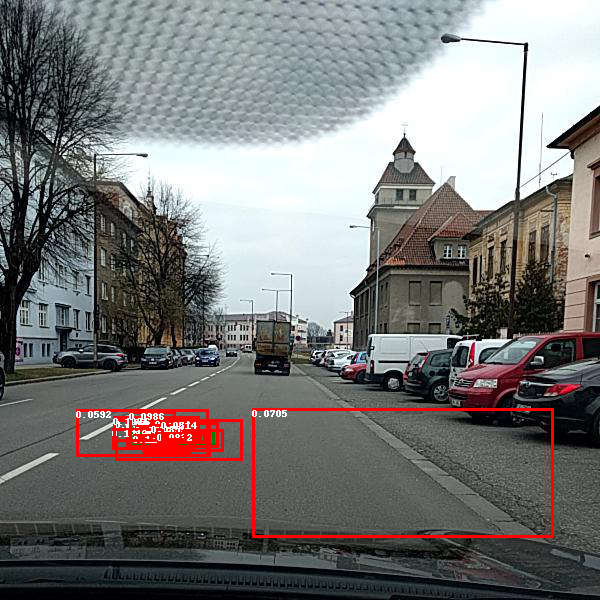

In [61]:
from PIL import ImageDraw

idx = 3
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# draw groundtruth
for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], 
    outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
    if score > 0.01:
       draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
       outline ="red", width =3)
       draw.text((boxes[0], boxes[1]), text = str(score))
image

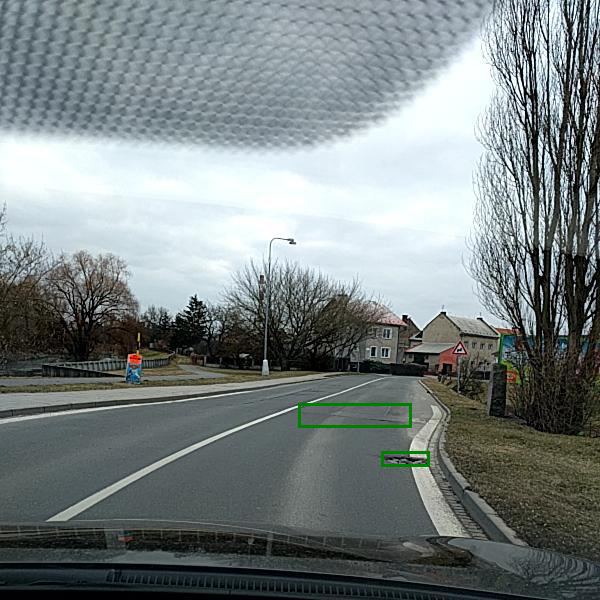

In [62]:
from PIL import ImageDraw

idx = 6
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# draw groundtruth
for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], 
    outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
    if score > 0.01:
       draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
       outline ="red", width =3)
       draw.text((boxes[0], boxes[1]), text = str(score))
image